<a href="https://colab.research.google.com/github/HxyScotthuang/CMPNN-Neptune/blob/withoutNeptune/TRI_SQR_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title [RUN] Install required libraries
import torch
torch.manual_seed(0)
def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
  Using cached torch_scatter-2.1.1.tar.gz (107 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl size=3513298 sha256=762be1191353ae8cca6cdafacc22407310c5c835eb9afaca5dbb989eb01256b7
  Stored in directory: /root/.cache/pip/wheels/ef/67/58/6566a3b61c6ec0f2ca0c2c324cd035ef2955601f0fb3197d5f
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
  Using cached torch_sparse-0.6.17.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.17-cp310-cp310-linux_x86_64.whl size=2738597 sha256=a11ad45c15c5866ff5a146903fdac8341886af

In [2]:
# @title [RUN] Import libraries and functions
import numpy as np
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.models import MLP
import torch.nn.functional as F
from torch_scatter import scatter
from torch_geometric.utils import degree
from torch_geometric.nn.pool import global_add_pool
from torch.utils import data as torch_data
import math
import torch_geometric
import random
from torch_geometric.loader import DataLoader
from torch_geometric.transforms.to_sparse_tensor import ToSparseTensor
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils.random import erdos_renyi_graph

#TRI-SQR Dataset

We proposed a synthetic dataset TRI-SQR, which consists of multiple pairs of knowledge graphs in form $(G_1,G_2)$ s.t. $G_1 = (V_1,E_1,R,c_1)$, $G_2 = (V_2,E_2,R,c_2)$ where $R = \{r_0,r_1,r_2\}$. For each pair, we constructed as follow:

1.   Generate an Erdos-Renyi graph $G_{\text{init}}$ with $5$ nodes and a random probability $p$. We randomly select one of the nodes as the source node $u$.
2.   $G_1$ is constructed by disjoint union $G_{\text{init}}$ with two triangles, one with edges relation of $r_1$, and the other with $r_2$. The target query is $r_3(u,v)$ for all $v$ in a triangle with an edge relation of $r_1$.
3.  Similarly, $G_2$ is constructed by disjoint union another copy of $G_{\text{init}}$ with two squares, one with edges relation of $r_1$, and the other with $r_2$. The target query is $r_3(u,v)$ for all $v$ in a square with an edge relation of $r_2$.

One example of such a pair can be shown in the following figure:

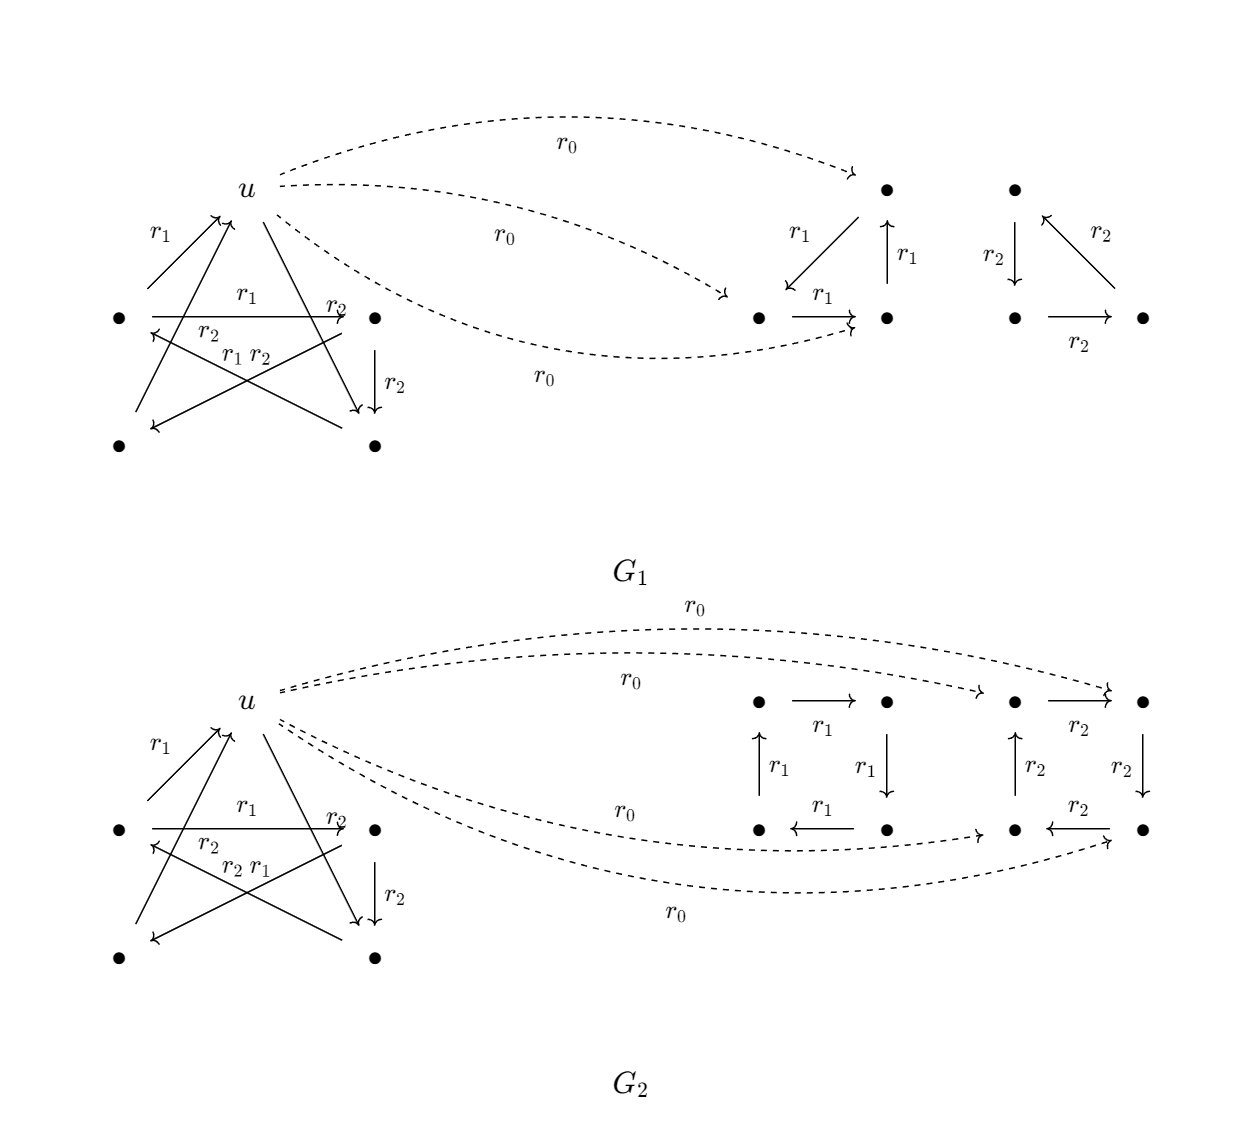

In [3]:
from torch_geometric.data import Data

edge_index_triangle_cluster = torch.tensor(
    [
        [0, 1, 2, 3, 4, 5],
        [1, 2, 0, 4, 5, 3],
    ],
    dtype=torch.long,
)
triangle_cluster_num_nodes = edge_index_triangle_cluster.max() + 1
edge_type_triangle_cluster = torch.tensor([1, 1, 1, 2, 2, 2], dtype=torch.long)

edge_index_square_cluster = torch.tensor(
    [
        [0, 1, 2, 3, 4, 5, 6, 7],
        [1, 2, 3, 0, 5, 6, 7, 4],
    ],
    dtype=torch.long,
)
square_cluster_num_nodes = edge_index_square_cluster.max() + 1
edge_type_square_cluster = torch.tensor([1, 1, 1, 1, 2, 2, 2, 2], dtype=torch.long)

In [4]:
def concat_two_graph(index_1, type_1, index_2, type_2):
    node_1 = torch.max(index_1.view(-1)) + 1
    index = torch.cat([index_1, index_2 + node_1], dim=-1)
    edge_type = torch.cat([type_1, type_2])
    return index, edge_type


def add_inverse_relation(index, edge_type):
    num_relations = 2
    index = torch.cat([index, index.flip(0)], dim=-1)
    edge_type = torch.cat([edge_type, edge_type + num_relations])
    return index, edge_type


def generate_target_index_type(fact_index, fact_type, tri, init_edge_index):
    # Generate r0
    init_cluster_num_nodes = init_edge_index.max() + 1
    if tri:
        target = 1
    else:
        target = 2
    target_type = []
    # To avoid negative sampling
    not_target_type = []
    # for triangle, so we connect u with r_1 triangle
    for index, item in enumerate(fact_index[0]):
        # enumerate over all edges
        if item >= init_cluster_num_nodes and fact_type[index] == target:
            # Add an edge over
            target_type.append([0, item.item()])
        elif item >= init_cluster_num_nodes and fact_type[index] != target:
            not_target_type.append([0, item.item()])
    assert len(target_type) == len(not_target_type)
    return (
        torch.tensor(target_type).t().contiguous(),
        torch.zeros(len(target_type), dtype=torch.int),
        torch.tensor(not_target_type).t().contiguous(),
    )

In [5]:
def create_data_instances(num_node=5):
    p = random.uniform(0.2, 1)
    edge_index_init_cluster = erdos_renyi_graph(
        num_nodes=num_node, edge_prob=p, directed=True
    )
    edge_type_init_cluster = torch.randint(
        low=1, high=3, size=(edge_index_init_cluster.size(1),)
    )

    tri_fact_index, tri_fact_type = edge_index_init_cluster, edge_type_init_cluster
    for i in range(1):
        tri_fact_index, tri_fact_type = concat_two_graph(
            tri_fact_index,
            tri_fact_type,
            edge_index_triangle_cluster,
            edge_type_triangle_cluster,
        )
    (
        tri_target_index,
        tri_target_type,
        tri_not_target_index,
    ) = generate_target_index_type(
        tri_fact_index, tri_fact_type, tri=True, init_edge_index=edge_index_init_cluster
    )
    tri_fact_index, tri_fact_type = add_inverse_relation(tri_fact_index, tri_fact_type)

    tri_data = Data(
        edge_index=tri_fact_index,
        edge_type=tri_fact_type,
        target_edge_index=tri_target_index,
        target_edge_type=tri_target_type,
        not_target_edge_index=tri_not_target_index,
    )

    sqr_fact_index, sqr_fact_type = edge_index_init_cluster, edge_type_init_cluster
    for i in range(1):
        sqr_fact_index, sqr_fact_type = concat_two_graph(
            sqr_fact_index,
            sqr_fact_type,
            edge_index_square_cluster,
            edge_type_square_cluster,
        )
    (
        sqr_target_index,
        sqr_target_type,
        sqr_not_target_index,
    ) = generate_target_index_type(
        sqr_fact_index,
        sqr_fact_type,
        tri=False,
        init_edge_index=edge_index_init_cluster,
    )
    sqr_fact_index, sqr_fact_type = add_inverse_relation(sqr_fact_index, sqr_fact_type)

    square_data = Data(
        edge_index=sqr_fact_index,
        edge_type=sqr_fact_type,
        target_edge_index=sqr_target_index,
        target_edge_type=sqr_target_type,
        not_target_edge_index=sqr_not_target_index,
    )

    tri_data.validate(raise_on_error=True)
    square_data.validate(raise_on_error=True)
    return tri_data, square_data

In [6]:
def generate_dataloader(length=10, seed=0, num_node=5):
    tri_graphs = []
    sqr_graphs = []
    for _ in range(length):
        tri_data, sqr_data = create_data_instances(num_node)

        tri_graphs.append(tri_data)
        sqr_graphs.append(sqr_data)
    aggr_list = list(zip(tri_graphs, sqr_graphs))
    random.Random(seed).shuffle(aggr_list)
    tri_graphs, sqr_graphs = zip(*aggr_list)
    split = int(len(aggr_list) * 0.7)
    train_list = tri_graphs[:split] + sqr_graphs[:split]
    test_list = tri_graphs[split:] + sqr_graphs[split:]

    train_dataloader = DataLoader(train_list)
    test_dataloader = DataLoader(test_list)
    return train_dataloader, test_dataloader

We generate $100$ graph pairs and assign $70$ pairs as the training set and the remaining $30$ pairs as the testing set ($140$ training graphs and $60$ testing graphs). In total, there are $490$ training triplets and $210$ testing triplets.



 For all node $v \notin G_{\text{init}}$, we want a higher score for all the links $r_0(u,v)$ if either $v$ is in a triangle consists of $r_1$ relation or $v$ is in a square consists of $r_2$ relation, and a lower score otherwise. For negative sampling, we choose counterpart triplets for each graph, that is, we take $r_0(u,v)$ for all $v$ in a triangle with an edge relation of $r_2$ in $G_1$ and in a square with an edge relation of $r_1$ in $G_2$. 

#Training Loop

In [7]:
def get_target_sampling(graph_data):
    target_edge_index = graph_data.target_edge_index
    target_edge_type = graph_data.target_edge_type
    not_target_edge_index = graph_data.not_target_edge_index
    h_index = torch.cat([target_edge_index[0], not_target_edge_index[0]]).unsqueeze(-1)
    t_index = torch.cat([target_edge_index[1], not_target_edge_index[1]]).unsqueeze(-1)
    r_index = torch.cat([target_edge_type, target_edge_type]).unsqueeze(-1)

    target = torch.zeros(h_index.size(0))
    target[: target_edge_index.size(-1)] = 1

    return torch.stack([h_index, t_index, r_index], dim=-1), target.unsqueeze(-1)

In [8]:
def train_and_validate(
    model,
    train_dataloader,
    num_epoch,
    lr,
):
    if num_epoch == 0:
        return

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    batch_id = 0
    for epoch in range(0, num_epoch):
        model.train()
        print(f"Epoch {epoch} begin")
        losses = []
        for graph_data in train_dataloader:
            batch, target = get_target_sampling(graph_data)
            pred = model(graph_data, batch)
            loss = F.binary_cross_entropy_with_logits(pred, target)
            neg_weight = torch.ones_like(pred)
            with torch.no_grad():
                neg_weight[:, 1:] = F.softmax(pred[:, 1:], dim=-1)

            loss = (loss * neg_weight).sum(dim=-1) / neg_weight.sum(dim=-1)
            loss = loss.mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            batch_id += 1
        avg_loss = sum(losses) / len(losses)
        print("Epoch %d end" % epoch)
        print("average binary cross entropy: %g" % avg_loss)

In [9]:
@torch.no_grad()
def test(model, test_dataloader):
    model.eval()
    corrects = []
    totals = []
    for graph_data in test_dataloader:
        batch, target = get_target_sampling(graph_data)
        pred = model(graph_data, batch)
        output = (F.sigmoid(pred) > 0.5).float()
        correct = (output == target).float().sum()
        corrects.append(correct)
        totals.append(target.size(0))
    accuracy = 100 * sum(corrects) / sum(totals)
    print("Accuracy = {}".format(accuracy))

#Model Definition

In [10]:
class CMPNNModule(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dims,
        num_relation,
        message_func="distmult",
        aggregate_func="pna",
        short_cut=False,
        layer_norm=False,
        concat_hidden=False,
        num_mlp_layer=2,
        dependent=True,
        readout=False,
    ):
        super(CMPNNModule, self).__init__()
        self.dims = [input_dim] + list(hidden_dims)
        self.num_relation = num_relation
        self.short_cut = (
            short_cut  # whether to use residual connections between GNN layers
        )
        self.concat_hidden = concat_hidden  # whether to compute final states as a function of all layer outputs or last
        self.readout = readout
        self.layers = nn.ModuleList()
        for i in range(len(self.dims) - 1):
            self.layers.append(
                CMPNNLayer(
                    self.dims[i],
                    self.dims[i + 1],
                    num_relation,
                    self.dims[0],
                    message_func,
                    aggregate_func,
                    layer_norm,
                    dependent,
                    readout,
                )
            )

        feature_dim = (
            sum(hidden_dims) if concat_hidden else hidden_dims[-1]
        ) + input_dim

        # additional relation embedding which serves as an initial 'query' for the NBFNet forward pass
        # each layer has its own learnable relations matrix, so we send the total number of relations, too
        self.query = nn.Embedding(num_relation, input_dim)
        self.mlp = nn.Sequential()
        mlp = []
        for i in range(num_mlp_layer - 1):
            mlp.append(nn.Linear(feature_dim, feature_dim))
            mlp.append(nn.ReLU())
        mlp.append(nn.Linear(feature_dim, 1))
        self.mlp = nn.Sequential(*mlp)

    def bellmanford(self, data, h_index, r_index, separate_grad=False):
        batch_size = len(r_index)

        # initialize queries (relation types of the given triples)
        query = self.query(r_index)
        index = h_index.unsqueeze(-1).expand_as(query)

        # initial (boundary) condition - initialize all node states as zeros
        boundary = torch.zeros(
            batch_size, data.num_nodes, self.dims[0], device=h_index.device
        )
        # by the scatter operation we put query (relation) embeddings as init features of source (index) nodes
        boundary.scatter_add_(1, index.unsqueeze(1), query.unsqueeze(1))
        size = (data.num_nodes, data.num_nodes)
        edge_weight = torch.ones(data.num_edges, device=h_index.device)

        hiddens = []
        edge_weights = []
        layer_input = boundary

        for layer in self.layers:
            if separate_grad:
                edge_weight = edge_weight.clone().requires_grad_()
            # Bellman-Ford iteration, we send the original boundary condition in addition to the updated node states
            hidden = layer(
                layer_input, query, data.edge_index, data.edge_type, size, edge_weight
            )
            if self.short_cut and hidden.shape == layer_input.shape:
                # residual connection here
                hidden = hidden + layer_input
            hiddens.append(hidden)
            edge_weights.append(edge_weight)
            layer_input = hidden

        # original query (relation type) embeddings
        node_query = query.unsqueeze(1).expand(
            -1, data.num_nodes, -1
        )  # (batch_size, num_nodes, input_dim)
        if self.concat_hidden:
            output = torch.cat(hiddens + [node_query], dim=-1)
        else:
            output = torch.cat([hiddens[-1], node_query], dim=-1)

        return {
            "node_feature": output,
            "edge_weights": edge_weights,
        }

    def forward(self, data, batch):
        h_index, t_index, r_index = batch.unbind(-1)
        shape = h_index.shape

        assert (h_index[:, [0]] == h_index).all()
        assert (r_index[:, [0]] == r_index).all()

        # message passing and updated node representations
        output = self.bellmanford(
            data, h_index[:, 0], r_index[:, 0]
        )  # (num_nodes, batch_size, feature_dim）
        feature = output["node_feature"]
        index = t_index.unsqueeze(-1).expand(-1, -1, feature.shape[-1])
        # extract representations of tail entities from the updated node states
        feature = feature.gather(
            1, index
        )  # (batch_size, num_negative + 1, feature_dim)

        # probability logit for each tail node in the batch
        # (batch_size, num_negative + 1, dim) -> (batch_size, num_negative + 1)
        score = self.mlp(feature).squeeze(-1)
        return score.view(shape)

In [11]:
class CMPNNLayer(MessagePassing):
    eps = 1e-6

    message2mul = {
        "transe": "add",
        "distmult": "mul",
    }

    def __init__(
        self,
        input_dim,
        output_dim,
        num_relation,
        query_input_dim,
        message_func="distmult",
        aggregate_func="pna",
        layer_norm=False,
        dependent=True,
        readout=False,
    ):
        super(CMPNNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_relation = num_relation
        self.query_input_dim = query_input_dim
        self.message_func = message_func
        self.aggregate_func = aggregate_func
        self.dependent = dependent
        self.readout = readout
        if self.readout:
            self.readout_transform = MLP(
                [input_dim * 3] + [input_dim] + [output_dim], norm=None
            )
        if layer_norm:
            self.layer_norm = nn.LayerNorm(output_dim)
        else:
            self.layer_norm = None

        self.activation = nn.ReLU()

        if self.aggregate_func == "pna":
            self.linear = nn.Linear(input_dim * 13, output_dim)
        else:
            self.linear = nn.Linear(input_dim * 2, output_dim)

        if dependent:
            # obtain relation embeddings as a projection of the query relation
            self.relation_linear = nn.Linear(query_input_dim, num_relation * input_dim)
        else:
            # relation embeddings as an independent embedding matrix per each layer
            self.relation = nn.Embedding(num_relation, input_dim)

    def forward(self, input, query, edge_index, edge_type, size, edge_weight=None):
        batch_size = len(query)

        if self.dependent:
            # layer-specific relation features as a projection of input "query" (relation) embeddings
            relation = self.relation_linear(query).view(
                batch_size, self.num_relation, self.input_dim
            )
        else:
            # layer-specific relation features as a special embedding matrix unique to each layer
            relation = self.relation.weight.expand(batch_size, -1, -1)
        if edge_weight is None:
            edge_weight = torch.ones(len(edge_type), device=input.device)

        # note that we send the initial boundary condition (node states at layer0) to the message passing
        # correspond to Eq.6 on p5 in https://arxiv.org/pdf/2106.06935.pdf
        output = self.propagate(
            input=input,
            relation=relation,
            edge_index=edge_index,
            edge_type=edge_type,
            boundary=input,
            size=size,
            edge_weight=edge_weight,
        )
        return output

    def message(self, input_j, boundary, relation, edge_type):
        relation_j = relation.index_select(self.node_dim, edge_type)

        if self.message_func == "transe":
            message = input_j + relation_j
        elif self.message_func == "distmult":
            message = input_j * relation_j
        elif self.message_func == "rotate":
            x_j_re, x_j_im = input_j.chunk(2, dim=-1)
            r_j_re, r_j_im = relation_j.chunk(2, dim=-1)
            message_re = x_j_re * r_j_re - x_j_im * r_j_im
            message_im = x_j_re * r_j_im + x_j_im * r_j_re
            message = torch.cat([message_re, message_im], dim=-1)
        else:
            raise ValueError("Unknown message function `%s`" % self.message_func)

        # augment messages with the boundary condition
        message = torch.cat(
            [message, boundary], dim=self.node_dim
        )  # (num_edges + num_nodes, batch_size, input_dim)

        return message

    def aggregate(self, input, edge_weight, index, dim_size):
        # augment aggregation index with self-loops for the boundary condition
        index = torch.cat(
            [index, torch.arange(dim_size, device=input.device)]
        )  # (num_edges + num_nodes,)
        edge_weight = torch.cat(
            [edge_weight, torch.ones(dim_size, device=input.device)]
        )
        shape = [1] * input.ndim
        shape[self.node_dim] = -1
        edge_weight = edge_weight.view(shape)

        if self.aggregate_func == "pna":
            mean = scatter(
                input * edge_weight,
                index,
                dim=self.node_dim,
                dim_size=dim_size,
                reduce="mean",
            )
            sq_mean = scatter(
                input**2 * edge_weight,
                index,
                dim=self.node_dim,
                dim_size=dim_size,
                reduce="mean",
            )
            max = scatter(
                input * edge_weight,
                index,
                dim=self.node_dim,
                dim_size=dim_size,
                reduce="max",
            )
            min = scatter(
                input * edge_weight,
                index,
                dim=self.node_dim,
                dim_size=dim_size,
                reduce="min",
            )
            std = (sq_mean - mean**2).clamp(min=self.eps).sqrt()
            features = torch.cat(
                [
                    mean.unsqueeze(-1),
                    max.unsqueeze(-1),
                    min.unsqueeze(-1),
                    std.unsqueeze(-1),
                ],
                dim=-1,
            )
            features = features.flatten(-2)
            degree_out = degree(index, dim_size).unsqueeze(0).unsqueeze(-1)
            scale = degree_out.log()
            scale = scale / scale.mean()
            scales = torch.cat(
                [torch.ones_like(scale), scale, 1 / scale.clamp(min=1e-2)], dim=-1
            )
            output = (features.unsqueeze(-1) * scales.unsqueeze(-2)).flatten(-2)
        else:
            output = scatter(
                input * edge_weight,
                index,
                dim=self.node_dim,
                dim_size=dim_size,
                reduce=self.aggregate_func,
            )

        return output

    def update(self, update, input):
        # node update as a function of old states (input) and this layer output (update)
        if self.readout:
            batch = torch.zeros(input.size(1), dtype=int)
            pool = global_add_pool(input, batch).repeat(1, input.size(1), 1)
            output = self.readout_transform(torch.cat([input, update, pool], dim=-1))
        else:
            output = self.linear(torch.cat([input, update], dim=-1))

        if self.layer_norm:
            output = self.layer_norm(output)
        if self.activation:
            output = self.activation(output)
        return output

# Experiments

We claim that C-MPNNs with sum readout can correctly predict all testing triplets, whereas C-MPNNs  without sum readout will fail to learn this pattern and achieve $50\%$ as random guessing. Theoretically, the TRI-SQR dataset is designed in such a way that any R-MPNN model assigns identical node representations to nodes in triangles and squares with the same relation type. Consequently, any C-MPNN model without global readout will be unable to determine which graph between $G_1$ and $G_2$ in the graph pair is being predicted, making it challenging to learn the conditional representation $\mathbf{h}_{u|v,q}$. However, we anticipate that a C-MPNN model with sum readout can differentiate between $G_1$ and $G_2$ in each pair, as it can access global information like the total number of nodes in the graph. This allows it to accurately identify the graph being predicted in the graph pair, even when the representations of the triangle and square with the same relation are identical. As a result, it can learn the target rules and achieve $100\%$ accuracy.

In [12]:
input_dim = 32
hidden_dims = [32, 32, 32, 32]
num_relation = 5
num_epoch = 200
lr = 1e-4
length = 100
num_node = 5

In [13]:
train_dataloader, test_dataloader = generate_dataloader(
    length=length, num_node=num_node
)
print(len(train_dataloader), len(test_dataloader))

140 60


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_type', 'target_edge_type', 'target_edge_index', 'edge_index', 'not_target_edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [14]:
CMPNNModel_GR = CMPNNModule(
    input_dim,
    hidden_dims,
    num_relation,
    message_func="distmult",
    aggregate_func="sum",
    short_cut=False,
    layer_norm=False,
    concat_hidden=False,
    num_mlp_layer=1,
    dependent=False,
    readout=True,
)

In [15]:
train_and_validate(
    CMPNNModel_GR,
    train_dataloader,
    num_epoch,
    lr,
)

Epoch 0 begin
Epoch 0 end
average binary cross entropy: 0.654735
Epoch 1 begin
Epoch 1 end
average binary cross entropy: 0.720568
Epoch 2 begin
Epoch 2 end
average binary cross entropy: 0.695224
Epoch 3 begin
Epoch 3 end
average binary cross entropy: 0.719236
Epoch 4 begin
Epoch 4 end
average binary cross entropy: 0.68953
Epoch 5 begin
Epoch 5 end
average binary cross entropy: 0.698431
Epoch 6 begin
Epoch 6 end
average binary cross entropy: 0.694315
Epoch 7 begin
Epoch 7 end
average binary cross entropy: 0.693591
Epoch 8 begin
Epoch 8 end
average binary cross entropy: 0.69505
Epoch 9 begin
Epoch 9 end
average binary cross entropy: 0.691501
Epoch 10 begin
Epoch 10 end
average binary cross entropy: 0.692909
Epoch 11 begin
Epoch 11 end
average binary cross entropy: 0.692991
Epoch 12 begin
Epoch 12 end
average binary cross entropy: 0.692713
Epoch 13 begin
Epoch 13 end
average binary cross entropy: 0.693392
Epoch 14 begin
Epoch 14 end
average binary cross entropy: 0.692658
Epoch 15 begin
Ep

In [16]:
test(CMPNNModel_GR, test_dataloader)

Accuracy = 98.57142639160156


In [17]:
CMPNNModel = CMPNNModule(
    input_dim,
    hidden_dims,
    num_relation,
    message_func="distmult",
    aggregate_func="sum",
    short_cut=False,
    layer_norm=False,
    concat_hidden=False,
    num_mlp_layer=2,
    dependent=False,
    readout=False,
)

In [18]:
train_and_validate(CMPNNModel, train_dataloader, num_epoch, lr)

Epoch 0 begin
Epoch 0 end
average binary cross entropy: 0.694234
Epoch 1 begin
Epoch 1 end
average binary cross entropy: 0.693783
Epoch 2 begin
Epoch 2 end
average binary cross entropy: 0.693684
Epoch 3 begin
Epoch 3 end
average binary cross entropy: 0.693422
Epoch 4 begin
Epoch 4 end
average binary cross entropy: 0.693454
Epoch 5 begin
Epoch 5 end
average binary cross entropy: 0.693435
Epoch 6 begin
Epoch 6 end
average binary cross entropy: 0.693356
Epoch 7 begin
Epoch 7 end
average binary cross entropy: 0.693324
Epoch 8 begin
Epoch 8 end
average binary cross entropy: 0.693301
Epoch 9 begin
Epoch 9 end
average binary cross entropy: 0.69328
Epoch 10 begin
Epoch 10 end
average binary cross entropy: 0.693264
Epoch 11 begin
Epoch 11 end
average binary cross entropy: 0.69325
Epoch 12 begin
Epoch 12 end
average binary cross entropy: 0.693236
Epoch 13 begin
Epoch 13 end
average binary cross entropy: 0.693225
Epoch 14 begin
Epoch 14 end
average binary cross entropy: 0.693215
Epoch 15 begin
Ep

In [19]:
test(CMPNNModel, test_dataloader)

Accuracy = 57.14285659790039
